Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

In [2]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler tsflex powershap --upgrade

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys

sys.path.append("../../src/")

In [5]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [6]:
df_feats = pd.read_parquet("../../features/mass_SS3_features_ALL__ext.parquet")
df_feats.shape

(62767, 366)

In [7]:
df_feats["label"].value_counts()

Sleep stage 2    29802
Sleep stage R    10581
Sleep stage 3     7653
Sleep stage W     6442
Sleep stage 1     4839
Sleep stage ?     3448
Name: label, dtype: int64

In [8]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62767 entries, 2000-01-01 21:28:00.010000 to 2000-01-02 07:14:30.010000
Columns: 366 entries, EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m30s_s=30s to patient_id
dtypes: float32(363), object(3)
memory usage: 88.8+ MB


In [9]:
sigs = list(set(c.split("__")[0] for c in df_feats.columns))
eeg_signals = [d for d in sigs if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(62767, 396)

In [10]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [11]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 131 131


(62767, 1051)

In [12]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62767 entries, 2000-01-01 21:28:00.010000 to 2000-01-02 07:14:30.010000
Columns: 1051 entries, EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m_s=30s to EEG F4-LER - EOG Left Horiz__delta/theta__w=30s_s=30s_shift=-1m
dtypes: float32(1048), object(3)
memory usage: 252.8+ MB


In [13]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [14]:
df_feats.shape

(59317, 1051)

In [15]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]
len(feat_cols)

1048

In [16]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

# ML

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier

In [18]:
from visualizations import plot_linear_classification_coefs
from visualizations import plot_learning_curve
from visualizations import plot_confusion_matrix

## The simple, linear pipeline

In [19]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

### Grouped 10-fold results for all the data for varying inputs

---------------------------------------- ['EEG'] ----------------------------------------
nb. features = 592
10-FOLD: TRAIN
  MACRO F1:           0.8139
  Balanced accuracy:  0.8234
  Accuracy:           0.86
  Log loss:           0.5149
10-FOLD: TEST
  MACRO F1:           0.79
  Balanced accuracy:  0.8003
  Accuracy:           0.8438
  Log loss:           0.6051

F1: 0.7925188317414837
ACC: 0.8443279329703121
KAPPA: 0.7737800043622998
LOG LOSS: 0.6036221091587136

               precision    recall  f1-score   support

Sleep stage 1       0.53      0.53      0.53      4793
Sleep stage 2       0.88      0.91      0.89     28580
Sleep stage 3       0.89      0.80      0.84      8488
Sleep stage R       0.86      0.84      0.85     10853
Sleep stage W       0.86      0.84      0.85      6603

     accuracy                           0.84     59317
    macro avg       0.80      0.78      0.79     59317
 weighted avg       0.84      0.84      0.84     59317



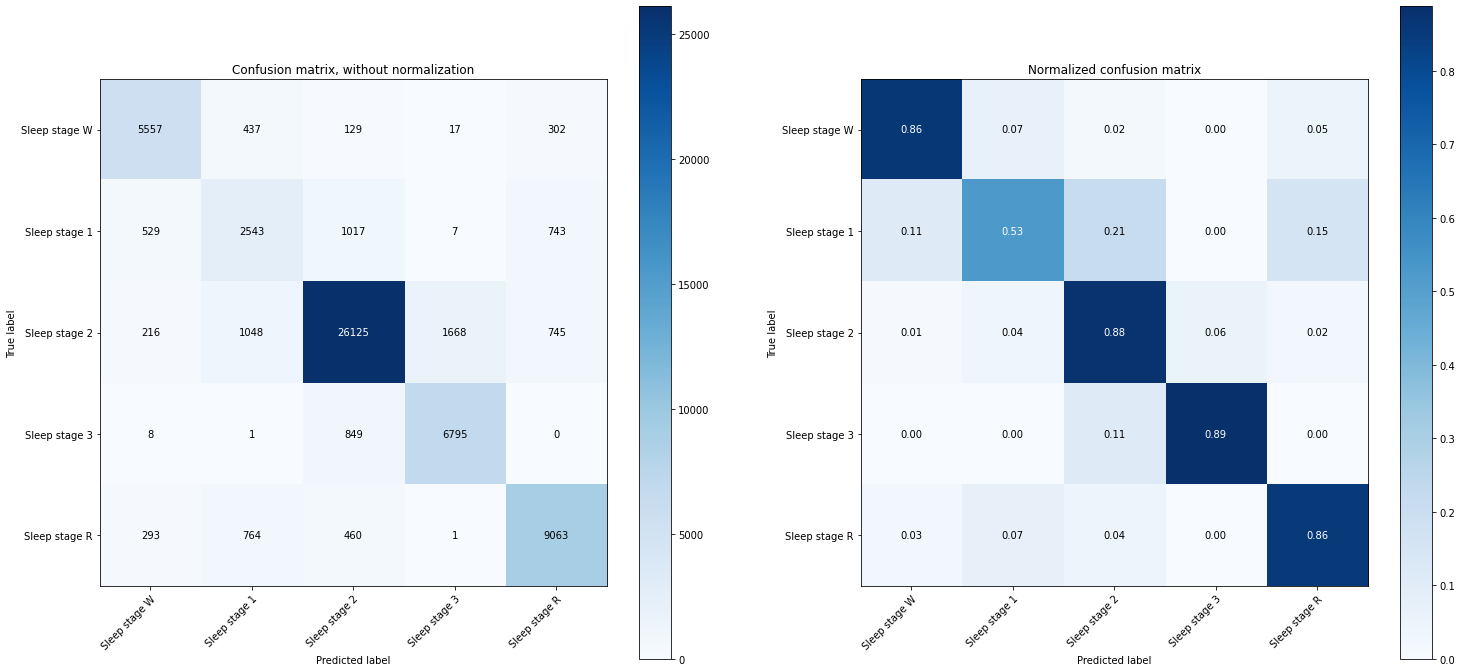





---------------------------------------- ['EEG', 'EOG'] ----------------------------------------
nb. features = 848
10-FOLD: TRAIN
  MACRO F1:           0.8207
  Balanced accuracy:  0.8295
  Accuracy:           0.8654
  Log loss:           0.5383
10-FOLD: TEST
  MACRO F1:           0.7912
  Balanced accuracy:  0.8015
  Accuracy:           0.8449
  Log loss:           0.6681

F1: 0.7936749326949755
ACC: 0.8453563059493906
KAPPA: 0.7751524154579963
LOG LOSS: 0.6669619221437528

               precision    recall  f1-score   support

Sleep stage 1       0.53      0.54      0.53      4727
Sleep stage 2       0.88      0.91      0.90     28645
Sleep stage 3       0.89      0.80      0.84      8488
Sleep stage R       0.86      0.84      0.85     10778
Sleep stage W       0.87      0.84      0.85      6679

     accuracy                           0.85     59317
    macro avg       0.80      0.79      0.79     59317
 weighted avg       0.85      0.85      0.85     59317



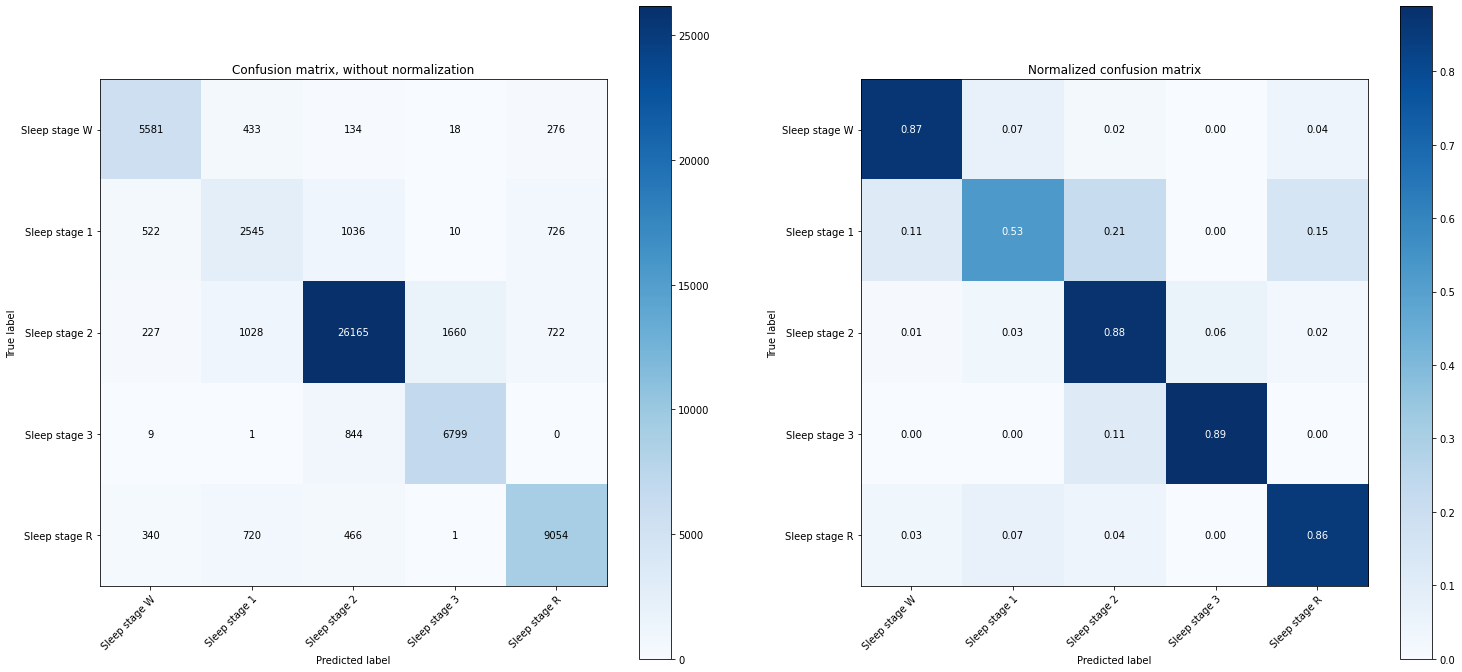





---------------------------------------- ['EEG', 'EMG'] ----------------------------------------
nb. features = 792
10-FOLD: TRAIN
  MACRO F1:           0.8244
  Balanced accuracy:  0.835
  Accuracy:           0.8664
  Log loss:           0.523
10-FOLD: TEST
  MACRO F1:           0.8014
  Balanced accuracy:  0.8118
  Accuracy:           0.8496
  Log loss:           0.6324

F1: 0.8034669948380418
ACC: 0.8498912622013925
KAPPA: 0.7819661522702983
LOG LOSS: 0.6327476038529585

               precision    recall  f1-score   support

Sleep stage 1       0.55      0.55      0.55      4837
Sleep stage 2       0.87      0.91      0.89     28540
Sleep stage 3       0.88      0.80      0.84      8492
Sleep stage R       0.87      0.85      0.86     10822
Sleep stage W       0.89      0.86      0.87      6626

     accuracy                           0.85     59317
    macro avg       0.81      0.79      0.80     59317
 weighted avg       0.85      0.85      0.85     59317



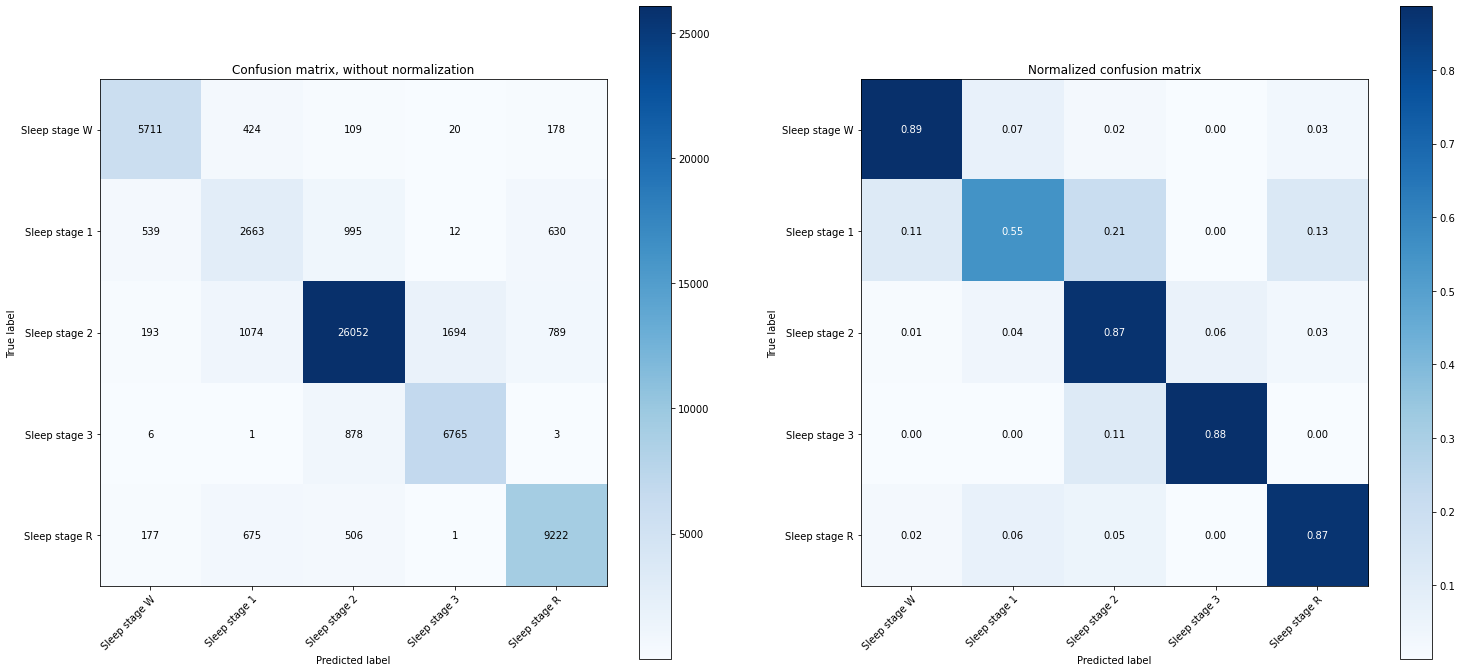

In [20]:
for inputs in [["EEG"], ["EEG", "EOG"], ["EEG", "EMG"]]:
    print("--" * 20, inputs, "--" * 20)

    feats_input = [f for f in feat_cols if f.split(" ")[0] in inputs]
    print("nb. features =", len(feats_input))

    ## Cross-validation
    # Total of 10 folds
    gkfold = StratifiedGroupKFold(n_splits=10)
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

    res = cross_validate(
        pipe,
        df_feats[feats_input],
        df_feats["label"],
        scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
        cv=cv,
        n_jobs=25,
        return_train_score=True,
        return_estimator=True,
    )

    print("10-FOLD: TRAIN")
    print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

    print("10-FOLD: TEST")
    print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

    preds = []
    preds_proba = []
    y_trues = []
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
    for fold_ix, (train_idx, test_idx) in enumerate(cv):
        X_train = df_feats[feats_input].iloc[train_idx]
        y_train = df_feats["label"].iloc[train_idx]
        X_test = df_feats[feats_input].iloc[test_idx]
        y_test = df_feats["label"].iloc[test_idx]
        
        estimator = res["estimator"][fold_ix]
        preds += [estimator.predict(X_test)]
        preds_proba += [estimator.predict_proba(X_test)]
        y_trues += [y_test]

    preds = np.hstack(preds)
    y_trues = np.hstack(y_trues)
    preds_proba = np.vstack(preds_proba)

    print()
    print("F1:", f1_score(preds, y_trues, average="macro"))
    print("ACC:", accuracy_score(preds, y_trues))
    print("KAPPA:", cohen_kappa_score(preds, y_trues))
    print("LOG LOSS:", log_loss(y_trues, preds_proba))
    print()

    print(classification_report(preds, y_trues))

    plt.figure(figsize=(25,12))
    ax = plt.subplot(1,2,1)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
    ax = plt.subplot(1,2,2)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)
    plt.show()

    print("\n\n\n")

## The simple, catboost pipeline

In [21]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

### Grouped 10-fold results for all the data for varying inputs

---------------------------------------- ['EEG'] ----------------------------------------
nb. features = 592
10-FOLD: TRAIN
  MACRO F1:           0.8984
  Balanced accuracy:  0.8846
  Accuracy:           0.925
  Log loss:           0.2142
10-FOLD: TEST
  MACRO F1:           0.8079
  Balanced accuracy:  0.7991
  Accuracy:           0.8625
  Log loss:           0.357

F1: 0.810120936708793
ACC: 0.8628386465937252
KAPPA: 0.7960458756032169
LOG LOSS: 0.35622959130661075

               precision    recall  f1-score   support

Sleep stage 1       0.49      0.63      0.55      3708
Sleep stage 2       0.92      0.89      0.91     30937
Sleep stage 3       0.83      0.87      0.85      7337
Sleep stage R       0.87      0.85      0.86     10757
Sleep stage W       0.89      0.87      0.88      6578

     accuracy                           0.86     59317
    macro avg       0.80      0.82      0.81     59317
 weighted avg       0.87      0.86      0.87     59317



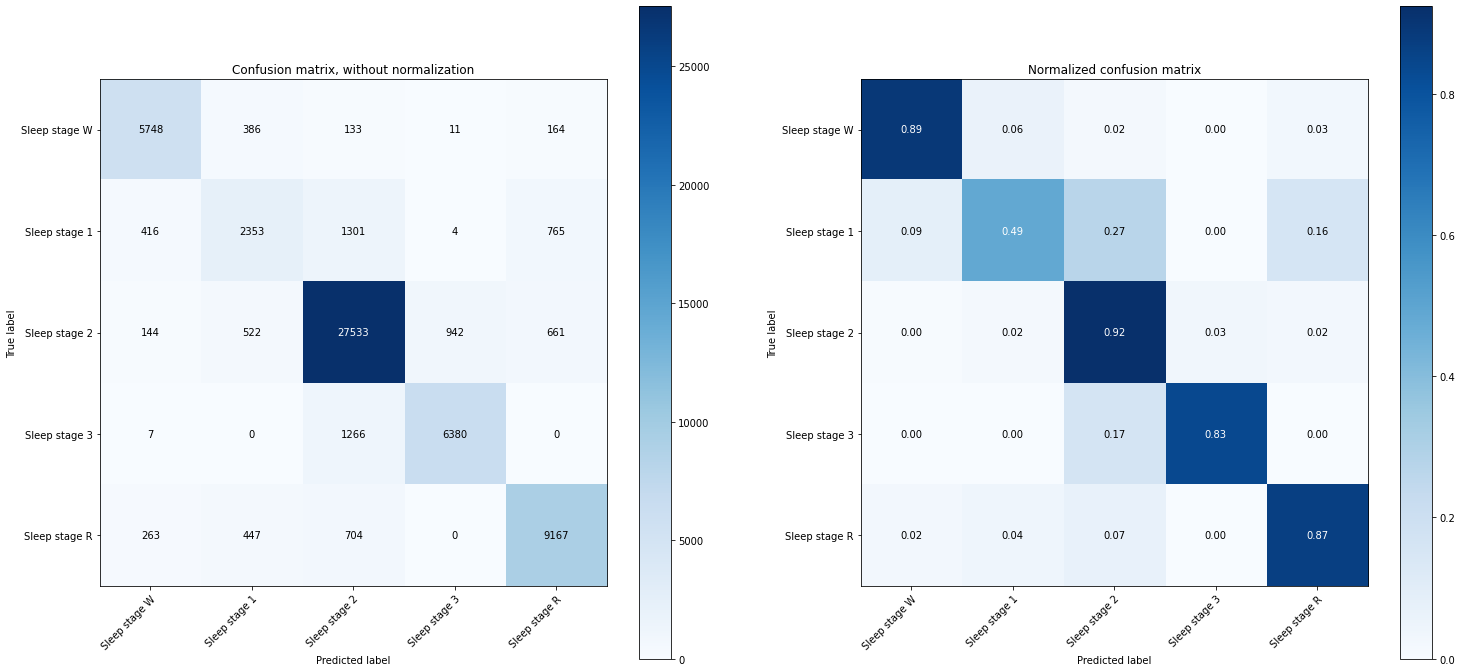





---------------------------------------- ['EEG', 'EOG'] ----------------------------------------
nb. features = 848
10-FOLD: TRAIN
  MACRO F1:           0.9006
  Balanced accuracy:  0.8868
  Accuracy:           0.9271
  Log loss:           0.2096
10-FOLD: TEST
  MACRO F1:           0.8069
  Balanced accuracy:  0.799
  Accuracy:           0.8629
  Log loss:           0.3558

F1: 0.8090889520214327
ACC: 0.8631926766357031
KAPPA: 0.7966434125388193
LOG LOSS: 0.3549445349688092

               precision    recall  f1-score   support

Sleep stage 1       0.47      0.63      0.54      3653
Sleep stage 2       0.92      0.89      0.91     30894
Sleep stage 3       0.84      0.87      0.85      7366
Sleep stage R       0.87      0.85      0.86     10770
Sleep stage W       0.90      0.87      0.89      6634

     accuracy                           0.86     59317
    macro avg       0.80      0.82      0.81     59317
 weighted avg       0.87      0.86      0.87     59317



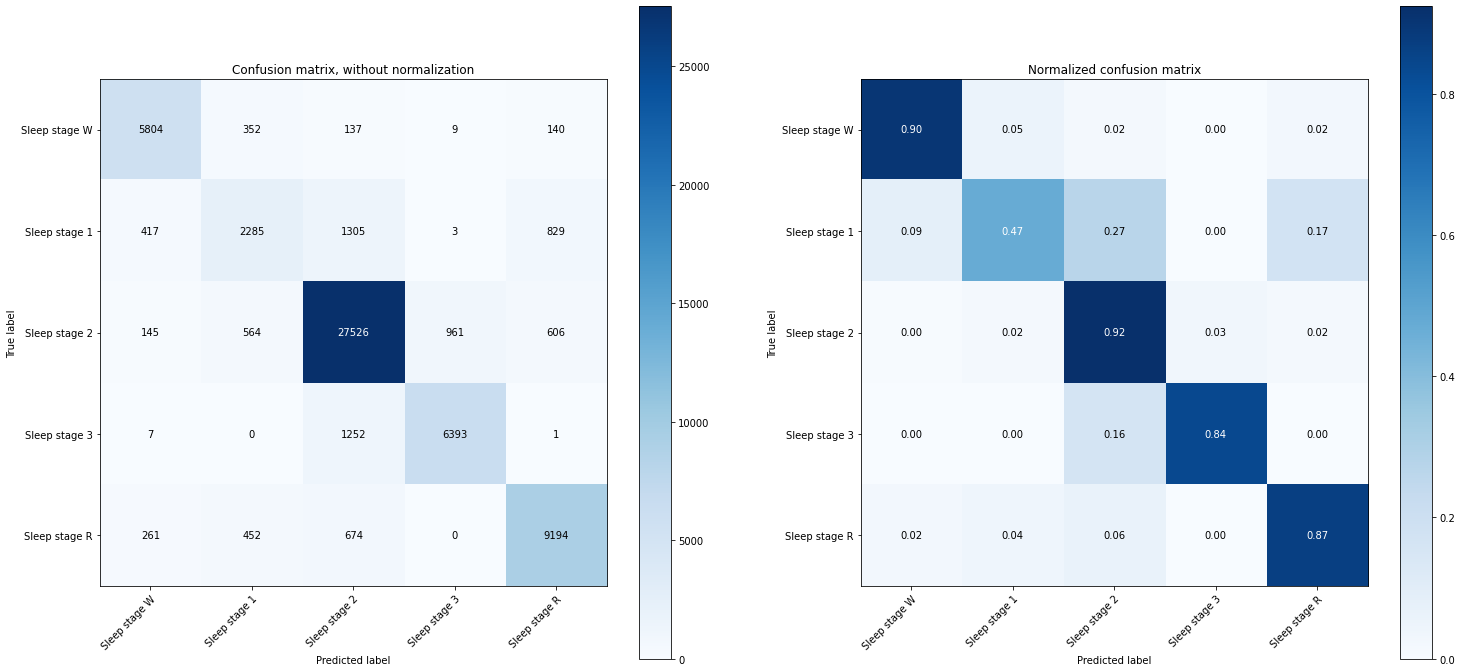





---------------------------------------- ['EEG', 'EMG'] ----------------------------------------
nb. features = 792
10-FOLD: TRAIN
  MACRO F1:           0.905
  Balanced accuracy:  0.8926
  Accuracy:           0.9291
  Log loss:           0.2023
10-FOLD: TEST
  MACRO F1:           0.8122
  Balanced accuracy:  0.8043
  Accuracy:           0.8641
  Log loss:           0.3479

F1: 0.8145567109204579
ACC: 0.8643053424819191
KAPPA: 0.7984620800762388
LOG LOSS: 0.3474216873748187

               precision    recall  f1-score   support

Sleep stage 1       0.51      0.62      0.56      3960
Sleep stage 2       0.92      0.89      0.91     30864
Sleep stage 3       0.83      0.87      0.85      7324
Sleep stage R       0.86      0.86      0.86     10603
Sleep stage W       0.90      0.89      0.90      6566

     accuracy                           0.86     59317
    macro avg       0.81      0.83      0.81     59317
 weighted avg       0.87      0.86      0.87     59317



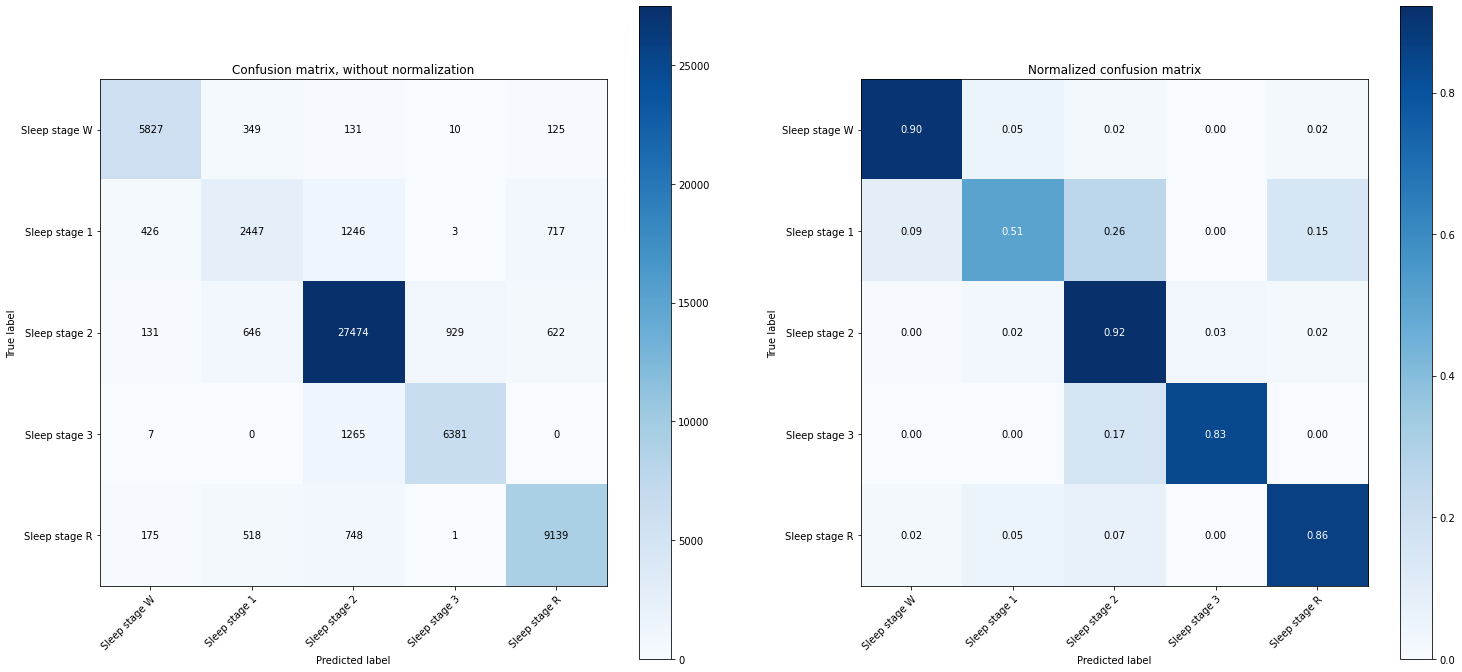

In [22]:
for inputs in [["EEG"], ["EEG", "EOG"], ["EEG", "EMG"]]:
    print("--" * 20, inputs, "--" * 20)

    feats_input = [f for f in feat_cols if f.split(" ")[0] in inputs]
    print("nb. features =", len(feats_input))

    ## Cross-validation
    # Total of 10 folds
    gkfold = StratifiedGroupKFold(n_splits=10)
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

    res = cross_validate(
        pipe,
        df_feats[feats_input],
        df_feats["label"],
        scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
        cv=cv,
        n_jobs=25,
        return_train_score=True,
        return_estimator=True,
    )

    print("10-FOLD: TRAIN")
    print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

    print("10-FOLD: TEST")
    print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

    preds = []
    preds_proba = []
    y_trues = []
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
    for fold_ix, (train_idx, test_idx) in enumerate(cv):
        X_train = df_feats[feats_input].iloc[train_idx]
        y_train = df_feats["label"].iloc[train_idx]
        X_test = df_feats[feats_input].iloc[test_idx]
        y_test = df_feats["label"].iloc[test_idx]
        
        estimator = res["estimator"][fold_ix]
        preds += [estimator.predict(X_test).ravel()]
        preds_proba += [estimator.predict_proba(X_test)]
        y_trues += [y_test]

    preds = np.hstack(preds)
    y_trues = np.hstack(y_trues)
    preds_proba = np.vstack(preds_proba)

    print()
    print("F1:", f1_score(preds, y_trues, average="macro"))
    print("ACC:", accuracy_score(preds, y_trues))
    print("KAPPA:", cohen_kappa_score(preds, y_trues))
    print("LOG LOSS:", log_loss(y_trues, preds_proba))
    print()

    print(classification_report(preds, y_trues))

    plt.figure(figsize=(25,12))
    ax = plt.subplot(1,2,1)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
    ax = plt.subplot(1,2,2)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)
    plt.show()

    print("\n\n\n")